# Create album

In [1]:
import pyreadr

DF = pyreadr.read_r('/Users/mxenoc/Desktop/workspace/butterfly/data/omics.RData')
DF = DF["DF"]

In [6]:
import butterfly.album

In [9]:
# Choose your responses, predictors, and size for the image
predictor = 'plasma_s'
response = 'plasma_l'
pixels = 40

In [3]:
album = butterfly.album.create_album(DF, predictor, pixels)

In [11]:
import butterfly.CNN

In [ ]:
#Decide which dataset you want to predict
plasma_l   = [col for col in DF if col.startswith('plasma_l')]
plasma_l.append("patientID")
plasma_l.append("trimester")    
plasma_l_df = DF[plasma_l]
#Make sure your B trimesters are properly converted to 4
#plasma_l_df['trimester'].unique()
#plasma_l_df = plasma_l_df.transpose()

#Get every combination of patient IDs in pairs of m's
# Function which returns subset or r length from n 
from itertools import combinations 

m = 2
IDs = plasma_l_df['patientID'].unique()
IDs = IDs.tolist()
exclude = list(combinations(IDs, m))

#exclude = t(combn(unique(DFraw[[2]]$patient.ID), m))

#Change the working directory
os.chdir('/Users/Maria/Desktop/Stanford/Python')

#Create the training dataset
import PCA
album = PCA.load_data()

from joblib import Parallel, delayed
import multiprocessing

num_cores = multiprocessing.cpu_count()

#results = Parallel(n_jobs=num_cores)(delayed(processInput)(i) for i in inputs)

# choose a number of time steps
# split into samples
#X, y = split_sequence(raw_seq, n_steps)
#XX = np.asarray(album)
#XX = XX.tolist()

#from 1 to len(exclude)
cv = 0 

XX = album
yy = plasma_l_df['plasma_l1'].values

for cv in range(len(exclude)):

    pt1ex = plasma_l_df.index[plasma_l_df['patientID'] == exclude[cv][0]].tolist()
    pt2ex = plasma_l_df.index[plasma_l_df['patientID'] == exclude[cv][1]].tolist()
    ptex = pt1ex+pt2ex
    
    #Divide in calibration and validation
    X_c = np.delete(XX, ptex, 0)
    y_c = np.delete(yy, ptex, 0)
    
    X_v = [XX[i]  for i in ptex]
    y_v = [yy[i] for i in ptex]
    
    # reshape from [samples, timesteps] into [samples, timesteps, features]
    n_steps = 40
    n_features = 40
    #X = X.reshape((X.shape[0], X.shape[1], n_features))
    # define model
    model = Sequential()
    model.add(Conv1D(filters=64, kernel_size=2, activation='relu', 
                     input_shape=(n_steps, n_features)))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Flatten())
    model.add(Dense(50, activation='relu'))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
    # fit model
    model.fit(X_c, y_c, epochs=1000, verbose=0)
    
    # demonstrate prediction
    x_input = X_v[0]
    x_input = x_input.reshape((1, n_steps, 1))
    
    
    yhat = model.predict(x_input, verbose=0)
    print(yhat)

In [13]:
y = x*8

In [15]:
np.cor(x,y)

NameError: name 'np' is not defined

In [13]:
import numpy as np 
import scipy.stats

a = np.array([1,2,3,4,5,6,7,8,9,10])
b = np.array([2,4,6,8,10,12,14,16,18,20])
b20 = b + 20
print(scipy.stats.pearsonr(a, b))
print(scipy.stats.pearsonr(a, b20))

(1.0, 0.0)
(1.0, 0.0)


In [4]:
a

array([0.04662735, 0.93231873, 0.30824045, 0.0369153 , 0.00351725,
       0.60648621, 0.99135605, 0.45247013, 0.95917002, 0.18969357])

In [5]:
b

array([0.39028166, 0.16409361, 0.30366678, 0.35866473, 0.05093098,
       0.40955674, 0.26773805, 0.25654017, 0.39211184, 0.89620065])

In [6]:
b20

array([20.39028166, 20.16409361, 20.30366678, 20.35866473, 20.05093098,
       20.40955674, 20.26773805, 20.25654017, 20.39211184, 20.89620065])

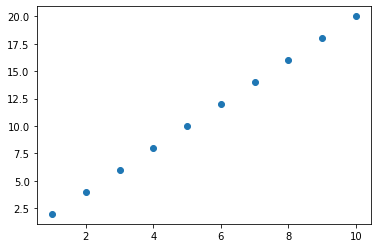

In [14]:
import matplotlib.pyplot as plt

plt.scatter(a,b)


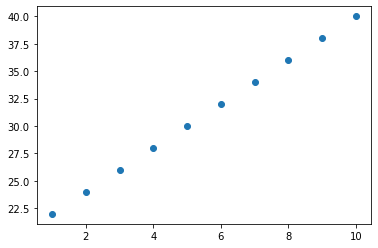

In [15]:
plt.scatter(a,b20)

